In [ ]:
!wget https://perso.esiee.fr/~gueurett/LV_Research/dataset_audio.zip
!unzip dataset_audio.zip

In [ ]:
# if wget desn't work (happens sometimes I believe it's because my school servers are blocking the access), import the dataset manualy and unzip on this block
!unzip dataset_audio.zip

In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import initializers
from pydub import AudioSegment
from sklearn import preprocessing
from scipy.io.wavfile import read
from tensorflow.keras import layers
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
def delete_excess(data):
  return data[:length_audio]

def add_average(data):
  result = np.zeros(shape=(length_audio,))
  end = data.shape[0]
  mean = np.mean(data[end-25:])
  result[:end] = data
  result[end:] = mean
  return result

In [ ]:
directory = "./dataset_audio/"
file_name = "I0474.wav"
path = directory + file_name

print(path)

rate, data = read(path)

print("rate = ", rate)
print("data.shape = ", data.shape)

length = data.shape[0] / rate
print("length(s): ", length, "s")
length_audio = data.shape[0]
print("length of unique audio:", length_audio)
nb_channels = data.shape[1]
print("number of channels: ", nb_channels)

n_samples = 0
for file_name in os.listdir(directory):
  n_samples += 1
print("number of files:", n_samples)

dataset = np.zeros(shape=(n_samples, length_audio))

# creating the dataset and labels

labels = np.zeros(shape=(n_samples,))

# reshaping the data if not exactly 4s
for index, filename in enumerate(os.listdir(directory)):
  if filename[0] == 'I': labels[index] = 1
  path = directory + filename
  rate, data = read(path)
  data = np.mean(data,axis=1)
  dim = data.shape
  if dim != (length_audio, nb_channels):
    if dim[0] > length_audio:
      result = delete_excess(data)
    else:
      result = add_average(data)
    dataset[index] = result
  else:
    dataset[index] = data

dataset_norm = (dataset - np.mean(dataset)) / np.std(dataset)  # let's normalize

print("----------------------------------")
print("| dataset.shape: ", dataset.shape)
print("| labels.shape : ", labels.shape)
print("----------------------------------")

./dataset_audio/I0474.wav
rate =  44100
data.shape =  (176400, 2)
length(s):  4.0 s
length of unique audio: 176400
number of channels:  2
number of files: 200
----------------------------------
| dataset.shape:  (200, 176400)
| labels.shape :  (200,)
----------------------------------


882


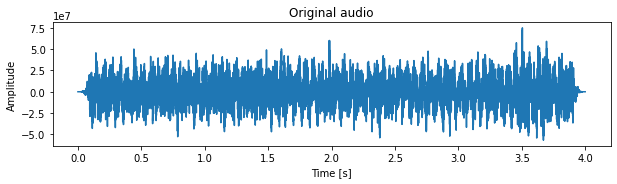

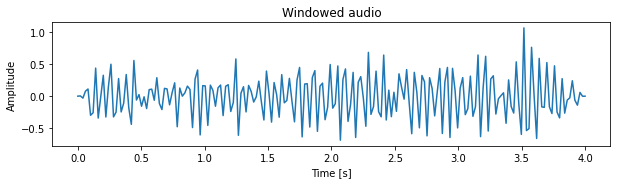

In [ ]:
#  time windows and features extraction

#  our audio is 4 seconds long, with a logic rate of 44100 (44100*4 = 176400)
#  therefore if we want time windows of 20ms (for example), our number of splits will be 4/0.002 = 2000

time_window = 0.02   # 20ms
len_split = int((length_audio * time_window) / length)
print(len_split)
n_splits = int(length_audio / len_split)
n_features = n_splits

data_windowed = np.zeros(shape=(n_samples, n_splits))

for index, sample in enumerate(dataset):
  data_windowed[index] = np.mean(np.array(np.split(sample, indices_or_sections=n_splits)), axis=1)

data_windowed = (data_windowed - np.mean(data_windowed)) / np.std(data_windowed)  # let's normalize

time = np.linspace(0., length, data.shape[0])
time_short = np.linspace(0., length, data_windowed.shape[0])

fig = plt.figure(figsize=(10, 5))
plt.subplot(2,1,1)
plt.plot(time, dataset[0, :])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Original audio")
plt.show()

fig = plt.figure(figsize=(10, 5))
plt.subplot(2,1,2)
plt.plot(time_short, data_windowed[0, :])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Windowed audio")
plt.show()

In [ ]:
def get_model_complete():

  model = tf.keras.Sequential()

  model.add(layers.Reshape((length_audio, 1), input_shape=(length_audio,)))

  model.add(layers.LSTM(20))

  model.add(layers.Dense(256))
  model.add(layers.ReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Dense(1, activation='sigmoid'))

  optimizer = Adam(0.0002, beta_1=0.5)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

  return model

In [ ]:
model = get_model_complete()

model.summary()

In [ ]:
history = model.fit(dataset_norm, labels, epochs=10, validation_split=0.3)

---
---

with windowed data now

In [ ]:
def get_model_reduced():

  model = tf.keras.Sequential()

  model.add(layers.Reshape((n_splits, 1), input_shape=(n_splits,)))

  model.add(layers.LSTM(200))

  model.add(layers.Dense(64))
  model.add(layers.ReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Dense(1, activation='sigmoid'))

  optimizer = Adam(0.0001, beta_1=0.5)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

  return model

In [ ]:
model = get_model_reduced()

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_6 (Reshape)         (None, 200, 1)            0         
                                                                 
 lstm_6 (LSTM)               (None, 200)               161600    
                                                                 
 dense_12 (Dense)            (None, 64)                12864     
                                                                 
 re_lu_6 (ReLU)              (None, 64)                0         
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 174,529
Trainable params: 174,529
Non-tr

In [ ]:
history = model.fit(data_windowed, labels, epochs=200, validation_split=0.3)

Epoch 1/200
5/5 [==============================] - 2s 124ms/step - loss: 0.6924 - binary_accuracy: 0.7071 - val_loss: 0.6910 - val_binary_accuracy: 0.6500
Epoch 2/200
5/5 [==============================] - 0s 30ms/step - loss: 0.6893 - binary_accuracy: 0.7500 - val_loss: 0.6885 - val_binary_accuracy: 0.6500
Epoch 3/200
5/5 [==============================] - 0s 31ms/step - loss: 0.6850 - binary_accuracy: 0.7500 - val_loss: 0.6848 - val_binary_accuracy: 0.6500
Epoch 4/200
5/5 [==============================] - 0s 25ms/step - loss: 0.6797 - binary_accuracy: 0.7500 - val_loss: 0.6791 - val_binary_accuracy: 0.6500
Epoch 5/200
5/5 [==============================] - 0s 23ms/step - loss: 0.6708 - binary_accuracy: 0.7500 - val_loss: 0.6682 - val_binary_accuracy: 0.6500
Epoch 6/200
5/5 [==============================] - 0s 20ms/step - loss: 0.6430 - binary_accuracy: 0.7500 - val_loss: 0.6405 - val_binary_accuracy: 0.6500
Epoch 7/200
5/5 [==============================] - 0s 18ms/step - loss: 0.6

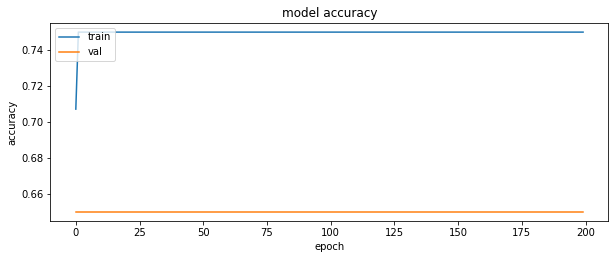

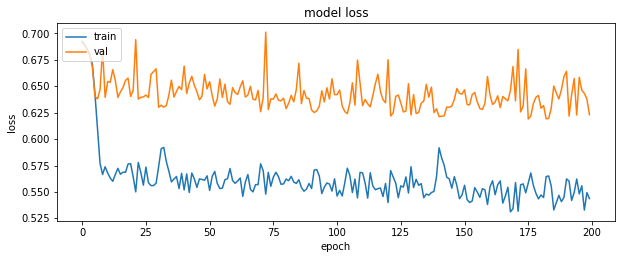

In [ ]:
fig = plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

fig = plt.figure(figsize=(10, 8))
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
number_splits = 6
number_runs   = 5
results_acc   = np.zeros(shape=(number_runs, number_splits))
results_loss  = np.zeros(shape=(number_runs, number_splits))


for run in range(number_runs):
  
  print("\n\n\nDoing the run number ", run+1)
  kfold = KFold(n_splits=number_splits, shuffle=True)

  # K-fold Cross Validation model evaluation
  fold_no = 1

  for split,(fold_train, fold_test) in enumerate(kfold.split(data_windowed, labels)):

    model = get_model_reduced()
    print("Training the fold number ", fold_no,"\n")
    history = model.fit(data_windowed[fold_train], labels[fold_train], epochs=30)

    scores = model.evaluate(data_windowed[fold_test], labels[fold_test], verbose=0)
    print("For the fold number ",  fold_no, ":\nloss = ", scores[0], "\naccuracy = ", scores[1]*100,"%")
    results_acc[run][split] = scores[1] * 100
    results_loss[run][split] = scores[0]

    # Increase fold number
    fold_no = fold_no + 1


results_acc = np.mean(results_acc, axis=1)
results_loss = np.mean(results_loss, axis=1)

results_acc = np.mean(results_acc)
results_loss = np.mean(results_loss)

print("\n\n\nWe obtain the following results:\nmean accuracy: ",results_acc,"%", "\nmean loss:",results_loss)




Doing the run number  1
Training the fold number  1 

Epoch 1/30
6/6 [==============================] - 2s 22ms/step - loss: 0.6925 - binary_accuracy: 0.6627
Epoch 2/30
6/6 [==============================] - 0s 19ms/step - loss: 0.6900 - binary_accuracy: 0.7108
Epoch 3/30
6/6 [==============================] - 0s 16ms/step - loss: 0.6865 - binary_accuracy: 0.7108
Epoch 4/30
6/6 [==============================] - 0s 14ms/step - loss: 0.6825 - binary_accuracy: 0.7108
Epoch 5/30
6/6 [==============================] - 0s 13ms/step - loss: 0.6757 - binary_accuracy: 0.7108
Epoch 6/30
6/6 [==============================] - 0s 12ms/step - loss: 0.6582 - binary_accuracy: 0.7108
Epoch 7/30
6/6 [==============================] - 0s 12ms/step - loss: 0.6008 - binary_accuracy: 0.7108
Epoch 8/30
6/6 [==============================] - 0s 13ms/step - loss: 0.6820 - binary_accuracy: 0.7108
Epoch 9/30
6/6 [==============================] - 0s 12ms/step - loss: 0.6195 - binary_accuracy: 0.7108
Epoch 1

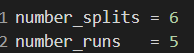

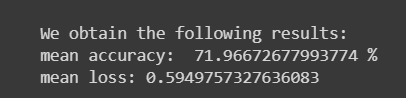